In [1]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph, START, END
import random

In [ ]:
class AgentState(TypedDict):
    player_name: str # input 
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int # input 
    upper_bound: int # input 


In [48]:
def greeting_node(state: AgentState) -> AgentState:
    state["player_name"] = f"Hello {state['player_name']}, Welcome to the game!"
    return state

def setup_game_node(state: AgentState) -> AgentState:
    """ Setup the game """

    state["target_number"] = random.randint(state["lower_bound"], state["upper_bound"])
    state["guesses"] = []
    state["attempts"] = 0
    state["hint"] = "Game is setup, make a guess!"
    state["lower_bound"] = 1
    state["upper_bound"] = 20
    print(f"{state['player_name']}. The game has begun. I am thinking of a number between {state['lower_bound']} and {state['upper_bound']}.")
    return state    

def guess_node(state: AgentState) -> AgentState:
    """ Generate a smarter guess based on the previous hint """
    
    """ 
    finding all the numbers between the lower and upper bounds that haven't been guessed yet, 
    so the game knows what valid options are still available to choose from

    For example, if the range is 1-10 
    and you've already guessed 3, 7, and 9, 
    then possible_guesses would be [1, 2, 4, 5, 6, 8, 10]
    """
    possible_guesses = [
                        i for i in range(state["lower_bound"], state["upper_bound"] + 1) 
                            if i not in state["guesses"]
                            ]

    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])
   
    state["guesses"].append(guess)
    state["attempts"] += 1
    
    print(f"Attempt {state['attempts']}: Guessing {guess} between {state['lower_bound']} and {state['upper_bound']}")

    return state

def hint_node(state: AgentState) -> AgentState:
    """ Provide a hint """

    latest_guess = state["guesses"][-1]
    target_number = state["target_number"]

    if latest_guess < target_number:
        state["hint"] = "higher"
        state["lower_bound"] = max(state["lower_bound"], latest_guess + 1)
        print(f"Hint: {state['hint']}   ")
    elif latest_guess > target_number:
        state["hint"] = "lower"
        state["upper_bound"] = min(state["upper_bound"], latest_guess - 1)
        print(f"Hint: {state['hint']}")
    else:
        state["hint"] = f"correct! You guessed the number {target_number}  in {state['attempts']} attempts"
        print(f"Success: {state['hint']}")
    
    return state

def should_continue_node(state: AgentState) -> AgentState:
    """ Check if the game should continue """
    latest_guess = state["guesses"][-1]

    if state["attempts"] >= 7:
        print("Game over! You've made 7 attempts. Better luck next time!")
        return "end"
    elif latest_guess == state["target_number"]:
        print(f"Success: {state['hint']}")
        return "end"
    else:
        print(f"Game is still on! Attempt: {state['attempts']}/7 Make a guess!")
        return "continue"
        


In [43]:
graph = StateGraph(AgentState)

graph.add_node("greeting", greeting_node)
graph.add_node("setup_game", setup_game_node)
graph.add_node("guess", guess_node)
graph.add_node("hint", hint_node)


graph.add_edge(START, "greeting")
graph.add_edge("greeting", "setup_game")
graph.add_edge("setup_game", "guess")
graph.add_edge("guess", "hint")

graph.add_conditional_edges(
    "hint",
    should_continue_node,
    {
        "continue": "guess",
        "end": END
    }
)

app = graph.compile()

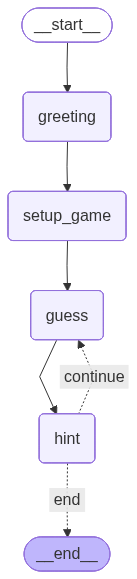

In [44]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [47]:
res = app.invoke({"player_name": "John", "lower_bound": 1, "upper_bound": 20})

Hello John, Welcome to the game!. The game has begun. I am thinking of a number between 1 and 20.
Attempt 1: Guessing 2 between 1 and 20
Success: correct! You guessed the number 2  in 1 attempts
Success: correct! You guessed the number 2  in 1 attempts
